# Functions

**Generate the B graph**

In [ ]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import random
from sklearn.metrics import f1_score
from time import time
import matplotlib.pyplot as plt
from numpy.ma.extras import average
from sklearn.metrics import confusion_matrix
import csv
import itertools

In [99]:
np.random.seed(0)

In [100]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# plt.rcdefaults()

### Data Generation Functions

In [102]:
def B_mat_symmetric(a, p):
    '''To generate a symmetric toeplitz matrix with a given vector 'a' '''
    # Vector 'a' can only be of length p (odd length indexing from 0 to p-1 and center at 0)
    # Initialize a zeros matrix of size nxn
    result = np.zeros((p, p))

    # Fill in the main diagonal with center element of a
    np.fill_diagonal(result, a[0])

    # Fill in sub/super-diagonals (below the main diagonal)
    for i in range(1, p):
        np.fill_diagonal(result[i:], -1*a[i]) # Sub-diagonals
        np.fill_diagonal(result[:,i:], -1*a[i]) # Super-diagonals
    return result


def B_mat_lowertriangular(a, p):
    '''To generate a lower triangular toeplitz matrix with a given vector 'a' '''
    # Vector 'a' can only be of length p (odd length indexing from 0 to p-1 and center at 0)
    # Initialize a zeros matrix of size nxn
    result = np.zeros((p, p))

    # Fill in the main diagonal with center element of a
    np.fill_diagonal(result, a[0])

    # Fill in sub/diagonals (below the main diagonal)
    for i in range(1, p):
        np.fill_diagonal(result[i:], -1*a[i]) # Sub-diagonals
    return result


def cov_x(p):
    """ Generate the covariance matrix for x"""
    sigma_x = np.eye(p)
    return sigma_x


def cov_y(sigma_x, B):
    """ Generate covariance matrix for Y i.e. (B^(-1).X.B^(-T)) since Y=B^(-1).X"""
    B_inv = np.linalg.solve(B, np.eye(B.shape[0]))
    sigma_y = B_inv@sigma_x@B_inv.T
    return sigma_y


def generate_y(mean_y, sigma_y, n_samples):
    """ Generate samples of Y"""
    y_samples = multivariate_normal.rvs(mean=mean_y, cov=sigma_y, size=n_samples)
    return y_samples

def samp_cov(y_samples):
    n_samples = len(y_samples)
    samp_cov_y = np.sum(np.array([np.outer(y_samples[i],y_samples[i]) for i in range(n_samples)]), axis=0)/n_samples 
    return samp_cov_y
    
def samp_cov2(y_samples):
    """ Generating sample covariance matrix """
    # n_samples = len(y_samples)
    # samp_cov_y = np.sum(np.array([np.outer(y_samples[i],y_samples[i]) for i in range(n_samples)]), axis=0)/n_samples 
    # return samp_cov_y
    # TODO: check if bias=True divides the sum by n_samples
    return np.cov(y_samples, rowvar=False, bias=True)


def soft(x, y):
    return np.sign(x) * np.maximum(np.abs(x) - y, 0)


def threshold(vec, threshold_value=0.002):
    vec1 = vec.copy()
    vec1[np.abs(vec) < threshold_value] = 0
    return vec1


def binarize_matrix(matrix):
    '''Converts non-zero elements to 1 and keeps zeros as zeros.'''
    binary_matrix = np.where(matrix != 0, 1, 0)
    return binary_matrix


def compute_recovery_rate_numpy(a_binary, true_a_binary):
    joint_ones = np.sum((a_binary == 1) & (true_a_binary == 1)) # True positives + False positives
    ones_true_a = np.sum(true_a_binary == 1) # True positives
    if ones_true_a == 0:
        return 0
    return joint_ones / ones_true_a


def create_sparse_vec_pos_def_2(dim, nonzeros, diag=20):
    ''' Function to create sparse vector(p x 1) which can generate symmetric +ve definite toeplitz matrix'''
    vec = np.zeros((dim,))
    vec[0] = diag
    nonzeros -= 1
    # selection of indicies with the non-zero entry (random selection)
    non_zero_indices = random.sample(range(1,dim),nonzeros)
    for idx in non_zero_indices:
        # Randomly assign values to non-zero entries 
        vec[idx] = random.randint(1,5)
    return vec


### Different functions for ADMM ###

def f1(a, S, sigma_x, rho, a2, mu1, regularized = False):
    """ Function evaluation for Newton method with regularization term based on ADMM
       TODO: verify this Tr[S.Theta_y] - logdet(Theta_y) + rho/2*||a1 - a2 + mu1||_1"""
    p = S.shape[0]
    a.reshape((-1,))
    B = B_mat_symmetric(a, p)
    theta_x = np.linalg.solve(sigma_x, np.eye(p))
    if regularized:
        # Added [1:] since we don't want to regularize a0
        reg_term = (rho/2)*np.linalg.norm(a[1:]-a2+mu1)
    else:
        reg_term = 0
    return np.trace(S@B.T@theta_x@B)-np.log(np.linalg.det(B.T@theta_x@B))+reg_term 


def f2(a, lam):
    """ Function evaluation of regularization term """
    return lam*np.linalg.norm(a[1:],1)
    
    
def f(a, S, sigma_x):
    a.reshape((-1,))
    B = B_mat_symmetric(a, S.shape[0])
    sigma_x_inv = np.linalg.solve(sigma_x, np.eye(S.shape[0]))
    return np.trace(S@B.T@sigma_x_inv@B) - np.log(np.linalg.det(B.T@sigma_x_inv@B))

In [103]:
def make_T_matrices(p, symmetric=False):
    """
    Returns a list [T0, T1, …, T(p-1)]
    for every j!=0 T[j] is a pxp matrix with jth super and subdiagonals with entries 1
    for j=0 its an Identity matrix
    """
    T_list = []
    I = np.eye(p)
    T_list.append(I)
    for j in range(1, p):
        M = np.zeros((p, p))
        # sub‑diagonal
        M[np.arange(j, p), np.arange(0, p-j)] = -1
        if symmetric:
            # super‑diagonal
            M[np.arange(0, p-j), np.arange(j, p)] = -1
        T_list.append(M)
    return T_list


Metrics

In [104]:
def kll(a, a_hat, sigma_x):
    ''' Computing the KL loss for the covariance matrices of Y'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    sigma_y = cov_y(sigma_x, B)
    sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    theta_y = np.linalg.solve(sigma_y, np.eye(p))
    return np.trace(sigma_y@theta_y_hat) - np.log(np.linalg.det(sigma_y@theta_y_hat)) - p

def rkll(a, a_hat, sigma_x):
    ''' Computing the reverse KL loss for the covariance matrices of Y'''
    return kll(a_hat, a, sigma_x)

def rte(a, a_hat, sigma_x):
    ''' Computing the relative trace error loss for the precision matrix'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    # sigma_y = cov_y(sigma_x, B)
    # sigma_y_hat = cov_y(sigma_x, B_hat)
    theta_y_hat = B_hat.T@B_hat
    theta_y = B.T@B
    return abs(1 - (np.trace(theta_y_hat)/np.trace(theta_y)))

def norm_loss(a, a_hat, sigma_x):
    ''' Computing the norm loss for the precision matrix'''
    p = len(a)
    B = B_mat_symmetric(a, p)
    B_hat = B_mat_symmetric(a_hat, p)
    # sigma_y = cov_y(sigma_x, B)
    # sigma_y_hat = cov_y(sigma_x, B_hat)
    # theta_y_hat = np.linalg.solve(sigma_y_hat, np.eye(p))
    # theta_y = np.linalg.solve(sigma_y, np.eye(p))
    theta_y_hat = B_hat.T@B_hat
    theta_y = B.T@B
    fro = np.linalg.norm(theta_y-theta_y_hat,ord='fro')
    spe = np.linalg.norm(theta_y-theta_y_hat,ord=2)
    l1 = np.linalg.norm(theta_y-theta_y_hat,ord=1)
    return fro, spe, l1

def scores(a, a_hat, threshold_value):
    ''' Computing the support recovery based scores for the precision matrix'''
    a_thr = threshold(a_hat, threshold_value=threshold_value) # Apply the threshold
    a_binary = binarize_matrix(a_thr)  # Change the output to a binary matrix to check for support recovery
    true_a_binary = binarize_matrix(a)  # True Support Vector
    cm = confusion_matrix(true_a_binary, a_binary)
    tn,fp,fn,tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    accuracy = (tn + tp)/np.sum(cm)
    specificity = (tn)/(tn + fp) # TN/(TN+FP)
    sensitivity = (tp)/(tp + fn) # TP/(TP+FN)
    MCC = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    return accuracy, specificity, sensitivity, MCC, cm

### Gradient Computation

In [106]:
def compute_gH(x, S, rho, a2, mu1, T_list, B, B_inv, theta_x, regularized = False):
    p=S.shape[0]
    # compute gradient
    if regularized:
        k = np.zeros_like(x)
        k[1:] = x[1:]-a2+mu1
    else:
        k = np.zeros_like(x)
    gradient = np.zeros((p,))
    for i in range(p):
            Ti = T_list[i] 
            gradient[i] = 2*np.trace((S@B@theta_x@Ti) - (B_inv@Ti)) + (rho*k[i])

    # compute hessian
    hessian = np.zeros((p,p))
    for i in range(p):
        Ti = T_list[i]
        for j in range(p):
            Tj = T_list[j]
            hessian[i,j] = 2*(np.trace(S@Ti@theta_x@Tj) + np.trace(B_inv@Ti@B_inv@Tj))
    if regularized:
        reg = rho*np.eye(p)
        reg[0,0] = 0
        hessian+=reg

    return gradient, hessian

###  Newtons Method

In [107]:
def compute_newton_step(gradient, hessian):
    """
    Computes the Newton step and decrement.

    Parameters:
    gradient (np.array): Gradient vector.
    hessian (np.array): Hessian matrix.

    Returns:
    delta_x_nt (np.array): Newton step.
    lambd (float): Newton decrement.
    """
    delta_x_nt = -np.linalg.solve(hessian, gradient)  # Newton step
    lambd_sqr = np.dot(gradient.T, hessian@gradient)  # Newton decrement
    return delta_x_nt, lambd_sqr

def backtracking_line_search(f, gradient, x, delta_x_nt, S, sigma_x, rho, a2, mu1,
                             regularized=False, alpha=0.01, beta=0.5):
    """
    Backtracking line search to ensure sufficient decrease.

    Parameters:
    f (function): Function to minimize.
    gradient (np.array): Gradient vector.
    x (np.array): Current point.
    delta_x_nt (np.array): Newton step.
    alpha (float): Alpha parameter for backtracking.
    beta (float): Beta parameter for backtracking.

    Returns:
    t (float): Step size.
    """
    t = 1  # Start with full step size
    p = S.shape[0]
    x_ = x + t * delta_x_nt
    # TODO: check if choelsky decomposition method of checking psd constraint is actually faster and reliable
    e_val, _ = np.linalg.eig(B_mat_symmetric(x_, p))
    i = 0
    while not np.all(e_val>0): 
        t *= beta # Reduce step size so that x + del_x is PSD
        x_ = x + t * delta_x_nt
        e_val, _ = np.linalg.eig(B_mat_symmetric(x_, p))
        i+=1
        if(i%5==0):
            print(f"   PSD-loop  iter={i:2d}  t={t:.2e}  λ_min={e_val[0]:.2e}")
        if i>20:
            t = 0
            print('Backtracking line search (I) went beyond 20 iterations')
            break
    x_ = x + t * delta_x_nt
    i = 0
    while (f(x_,S,sigma_x,rho,a2,mu1,regularized=regularized)\
           >f(x,S,sigma_x,rho,a2,mu1,regularized=regularized)\
           + alpha*t*np.dot(gradient.T,delta_x_nt)):
        t *= beta  # Reduce step size
        x_ = x + t * delta_x_nt
        # if(i%5==0):
            # print(f"   Armijo    t={t:.2e}")
        if (i>20) or (t==0):
            t = 0
            print('Backtracking line search (II) went beyond 20 iterations')
            break
    return t


def projection_Rp(x):
    y = np.maximum(x, np.zeros_like(x))
    return y


def newton_method(f, x0, S, sigma_x, rho, a2, mu1, T_list, epsilon=1e-6, alpha=0.01, beta=0.5,
                  regularized=False, backtracking=False, projection=False):
    """
    Implements Newton's method for optimization.

    Parameters:
    f (function): Function to minimize.
    grad_f (function): Gradient function.
    hessian_f (function): Hessian function.
    x0 (np.array): Initial point.
    epsilon (float): Stopping criterion for Newton decrement.
    alpha (float): Alpha parameter for backtracking.
    beta (float): Beta parameter for backtracking.

    Returns:
    x (np.array): Optimized point.
    """
    x = x0
    i = 0
    p=S.shape[0]
    theta_x = np.linalg.solve(sigma_x, np.eye(p))

    while True:
        B = sum(x[j]*T_list[j] for j in range(p))
        B_inv = np.linalg.solve(B, np.eye(p))
        
        gradient,hessian = compute_gH(x, S, rho, a2, mu1, T_list, B, B_inv,theta_x, regularized=regularized)
        
        # Compute Newton step and decrement
        delta_x_nt, lambd_sqr = compute_newton_step(gradient, hessian)
        
        # Stopping criterion
        if lambd_sqr / 2 <= epsilon:
            print('Stopping Criteria Met at iteration ', i)
            print(lambd_sqr, delta_x_nt)
            # print(i)
            break

        # Backtracking line search
        if backtracking:
            # print("line search")
            t = backtracking_line_search(f, gradient, x, delta_x_nt, S, sigma_x, rho, a2, mu1,
                                         regularized=regularized, alpha=alpha, beta=beta)
            print(f"line search step size t = {t:.2e}")
        else:
            t = 1
        # print(t)
            
        # Update x
        x_old = x.copy()
        x = x + t*delta_x_nt

        # Project x on R+
        if projection:
            x = projection_Rp(x)
        
        if i%10==0:
            # print(lambd_sqr, delta_x_nt)
            # print(i)
            print('Newton algorithm finished 10 iterations, lambda_sqr: ', lambd_sqr)
            
        if (i>=20):
            print('Newton algorithm finished 50 iterations')
            break
        
        if (i>1) and (np.linalg.norm(x_old-x)<=epsilon):
            print('not much change in x observed')
            print(i)
            break
        i+=1
    return x


### Pseudo Version of ADMM (Since f1 is not in closed form)

#### ADMM

In [108]:
def ADMM_newton(f, iterations, rho, lambda_param, S, sigma_x, a, T_list, epsilon=1e-6,
                alpha=0.5, beta=0.7, regularized=False, backtracking=True,
                projection=True, perturbed=False, tol=1e-4):
    p = S.shape[0]
    e0 = np.zeros((p,))
    e0[0] = 1
    a1 = e0.copy()
    a2 = np.zeros((p-1,))
    mu1 = np.zeros((p-1,))
    if perturbed:
        a1 = a + 0.1*np.random.randn(p)
        a2 = a[1:] + 0.1*np.random.randn(p-1)
    if regularized:
        print('Regularized - ADMM + Newton')
        for i in range(iterations):       
            print('='*50, "iteration ", i, '='*50)
            a2_old = a2.copy()
            a1_ = newton_method(f, a1, S, sigma_x, rho, a2, mu1, T_list, epsilon=epsilon,
                                alpha=alpha, beta=beta, regularized=regularized,
                                backtracking=backtracking, projection=projection)
            print("Completed Newton Iteration")
            a2_ = soft(a1_[1:]+mu1,lambda_param/rho)
            mu1_ = mu1 + (a1_[1:]-a2_)
            a1, a2, mu1 = a1_, a2_, mu1_

            primal_res = np.linalg.norm(a1[1:] - a2)
            dual_res = np.linalg.norm(rho * (a2 - a2_old))
            if(i%10==0):
                print(f"Primal: {primal_res}, Dual: {dual_res}, tol: {tol}")
            if primal_res <= tol and dual_res <= tol:
                break

    else:
        print('Unregularized - Newton')
        for i in range(iterations):       
            print('='*50, "iteration ", i, '='*50)
            a1_ = newton_method(f, a1, S, sigma_x, rho, a2, mu1, T_list, epsilon=epsilon,
                                alpha=alpha, beta=beta, regularized=regularized,
                                backtracking=backtracking, projection=projection)
            a1 = a1_
    return a1, a2, mu1

### Simulations - Symmetric Case

In [109]:
class SolverArgs:
    def __init__(self, p=50, d=15, const=5, rho=1, lambda_param=0.01, iterations=50,
                 regularize=True, backtrack=True, project=True, perturb=False, num_rep=50, n_samples=None):
        self.p = p
        self.d = d
        self.const = const
        self.rho = rho
        self.lambda_param = lambda_param
        self.iterations = iterations
        self.regularize = regularize
        self.backtrack = backtrack
        self.project = project
        self.perturb = perturb
        self.num_rep = num_rep
        self.n_samples = n_samples

In [110]:
class Solver:
    def __init__(self, args: SolverArgs):
        self.args = args

    def solve(self,epsilon=1e-4,alpha=0.1,beta=0.7,):
        p = self.args.p
        d = self.args.d
        const = self.args.const
        rho = self.args.rho
        lambda_param = self.args.lambda_param
        iterations = self.args.iterations
        regularize = self.args.regularize
        backtrack = self.args.backtrack
        project = self.args.project
        perturb = self.args.perturb
        num_rep = self.args.num_rep
        n_samples = self.args.n_samples

        if n_samples is None:
            n_samples = int(const * (d * d * np.log(p))) 
        print("Number of samples N:", n_samples)
        data = {}
        T_list=make_T_matrices(p, symmetric=True)

        print('Dimensions of Matrix = ', p, 'Sparsity = ', d)
        for rep in range(num_rep):
            a = create_sparse_vec_pos_def_2(p, d, diag=d * 10)
            B0 = B_mat_symmetric(a, p)
            # B0_inv = np.linalg.inv(B0)
            sigma_x = cov_x(p)
            sigma_y = cov_y(sigma_x, B0)
            y_samp = generate_y(np.zeros((p,)), sigma_y, n_samples)
            S = samp_cov(y_samp)

            total_t1 = time()
            print('_' * 50, 'Run = ', rep, '_' * 50)
            a1, a2, mu1 = ADMM_newton(
                f1,
                iterations,
                rho,
                lambda_param,
                S,
                sigma_x,
                a,
                T_list,
                epsilon=epsilon,
                alpha=alpha,
                beta=beta,
                regularized=regularize,
                backtracking=backtrack,
                projection=project,
                perturbed=perturb
            )
            total_t2 = time()
            print('Total time taken for a run = ', total_t2 - total_t1)

            run_data = {
                'p': p,
                'd': d,
                'const': const,
                'num_samples': n_samples,
                'lambda': lambda_param,
                'rho': rho,
                'iterations': iterations,
                'a': a,
                'samp_y': y_samp,
                'f_reg': regularize,
                'f_back': backtrack,
                'f_proj': project,
                'f_perturb': perturb,
                'a1': a1,
                'a2': a2,
                'mu1': mu1,
                'sigma_x': sigma_x
            }
            data[rep] = run_data

        return data
    
    def evaluate(self, data):
        num_rep = self.args.num_rep
        keys = list(data[0].keys())
        threshold_range = 0.01 * np.arange(101)

        best_thr = []
        best_rate = []
        best_acc = []
        best_f1 = []
        best_cm = []

        kll_const = []
        rkll_const = []
        rte_const = []
        norm_const = []
        scores_const = []

        for rep in range(num_rep):
            a = data[rep][keys[7]]
            a1 = data[rep][keys[-4]]
            sigma_x = data[rep][keys[-1]]
            true_a_binary = binarize_matrix(a)
            thr_rate = []
            thr_cm = []
            thr_acc = []
            thr_f1 = []

            for thr in threshold_range:
                a_thr = threshold(a1, threshold_value=thr)
                a_binary = binarize_matrix(a_thr)
                rate = compute_recovery_rate_numpy(a_binary, true_a_binary)
                cm = confusion_matrix(true_a_binary, a_binary)
                accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)

                thr_rate.append(rate)
                thr_cm.append(cm)
                thr_acc.append(accuracy)
                thr_f1.append(f1_score(true_a_binary, a_binary))

            idx = np.argmax(np.array(thr_acc))
            best_thr.append(threshold_range[idx])
            print(f"Best threshold: {best_thr}")
            best_rate.append(thr_rate[idx])
            best_acc.append(thr_acc[idx])
            best_f1.append(thr_f1[idx])
            best_cm.append(thr_cm[idx])

            a_thr = threshold(a1, threshold_value=threshold_range[idx])
            a_binary = binarize_matrix(a_thr)

            kll_const.append(kll(a, a_thr, sigma_x))
            rkll_const.append(rkll(a, a_thr, sigma_x))
            rte_const.append(rte(a, a_thr, sigma_x))
            norm_const.append(norm_loss(a, a_thr, sigma_x))
            scores_const.append(scores(a, a1, threshold_value=threshold_range[idx]))

        metrics = {
            'avg_acc': average(best_acc),
            'avg_f1': average(best_f1),
            'avg_rate': average(best_rate),
            'avg_kll': average(kll_const),
            'avg_rkll': average(rkll_const),
            'avg_rte': average(rte_const),
            'avg_fro': average([n[0] for n in norm_const]),
            'avg_spec': average([n[1] for n in norm_const]),
            'avg_l1': average([n[2] for n in norm_const]),
            'best_thr': best_thr,
            'best_cm': best_cm,
        }

        return metrics

Dry test

In [86]:
defaultArgs = SolverArgs(p=75, num_rep=1, const= 5, d=15)
defaultSolver = Solver(defaultArgs)
data = defaultSolver.solve()

Number of samples N: 4857
Dimensions of Matrix =  75 Sparsity =  15
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search step size t = 1.00e+00
Newton algorithm finished 10 iterations, lambda_sqr:  3374845.6831609835
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00


c:\Users\rohit\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2139: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


line search step size t = 1.00e+00
line search step size t = 1.00e+00
Stopping Criteria Met at iteration  9
2.9199327673043175e-05 [ 2.90829292e-01  7.89265955e-06  3.17770461e-05  1.71736700e-05
  2.95875554e-05  2.90245247e-05  1.13330352e-05  1.84793931e-04
 -2.26301452e-03  1.90415893e-04  5.40542693e-06  1.44321262e-05
  1.43618960e-05  2.83542475e-05  3.85068991e-05  1.73016198e-05
  1.24719870e-05  8.01667346e-06  4.09342195e-05  1.44195412e-05
  1.47269680e-05  9.82204277e-06  1.60189986e-04  1.26116090e-05
  3.61998816e-06  1.88978375e-05  4.70608111e-07  1.86240488e-04
 -8.83360748e-04  1.82843528e-05  1.18533772e-05  1.82602097e-05
  2.58699056e-05 -3.61834545e-03  1.58112729e-04  3.81846360e-06
  2.68293661e-05  5.83200510e-06  9.19802536e-06  8.73952798e-05
  8.22129210e-06  1.12657130e-04  6.67998763e-06  4.08062821e-06
  6.83862961e-06  1.10734109e-04  1.31877017e-05  7.86108249e-06
  7.36592227e-05  4.38342253e-05  8.38280714e-06  2.59597316e-06
  7.00910931e-06 -2.7548

In [92]:
defaultSolver.evaluate(data)

Best threshold: [0.18]


{'avg_acc': 0.9466666666666667,
 'avg_f1': 0.846153846153846,
 'avg_rate': 0.7333333333333333,
 'avg_kll': 0.3396754765502692,
 'avg_rkll': 0.32863199058580506,
 'avg_rte': 0.021675567615809355,
 'avg_fro': 17583.71467528446,
 'avg_spec': 4754.953219248948,
 'avg_l1': 10027.45850487437}

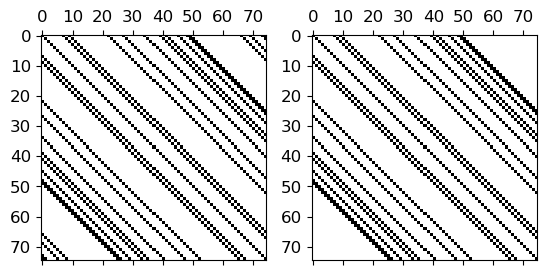

In [111]:
plt.subplot(1,2,1)
plt.spy(B_mat_symmetric(data[0]['a'], len(data[0]['a'])))
plt.subplot(1,2,2)
plt.spy(B_mat_symmetric(threshold(data[0]['a1'], 0.18), len(data[0]['a1'])))

Grid search

In [112]:
p_values = [25, 50, 75, 100]
lambda_grid = [0.01, 0.05, 0.1, 0.2]
rho_grid = [0.5, 1.0, 2.0]

results = []

for p in p_values:
    best_loss = float('inf')
    best_params = None

    for lamb, rho in itertools.product(lambda_grid, rho_grid):
        args = SolverArgs(p=p, lambda_param=lamb, rho=rho, num_rep=10, n_samples=2000)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)

        result_row = {
            'p': p,
            'lambda': lamb,
            'rho': rho,
            **metrics
        }
        results.append(result_row)

        if metrics['avg_kll'] < best_loss:
            best_loss = metrics['avg_kll']
            best_params = result_row

    print(f"Best for p={p}:", best_params)

# Save to CSV
with open('grid_search_results.csv', mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print("Results saved to 'grid_search_results.csv'")


Number of samples N: 2000
Dimensions of Matrix =  25 Sparsity =  15
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search step size t = 1.00e+00
Newton algorithm finished 10 iterations, lambda_sqr:  124994.37124026507
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
Stopping Criteria Met at iteration  8
9.013541141269454e-06 [8.99301538e+00 3.47037568e-03 1.66498518e-03 8.86699288e-04
 9.30177652e-04 3.24336439e-04 2.42739017e-04 3.11977970e-04
 2.19911391e-04 2.76005047e-03 4.01010273e-03 2.91216059e-03
 2.57153181e-03 5.05566254e-04 1.20091490e-03 1.45554867e-03
 1.32906392e-04 1.579

C:\Users\rohit\AppData\Local\Temp\ipykernel_10276\49079499.py:53: RuntimeWarning: invalid value encountered in scalar divide
  MCC = ((tp*tn)-(fp*fn))/np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))


Best threshold: [0.0, 0.0]
Best threshold: [0.0, 0.0, 0.0]
Best threshold: [0.0, 0.0, 0.0, 0.0]
Best threshold: [0.0, 0.0, 0.0, 0.0, 0.0]
Best threshold: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best threshold: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best threshold: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best threshold: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Best threshold: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Number of samples N: 2000
Dimensions of Matrix =  25 Sparsity =  15
__________________________________________________ Run =  0 __________________________________________________
Regularized - ADMM + Newton
================================================== iteration  0 ==================================================
line search step size t = 1.00e+00
Newton algorithm finished 10 iterations, lambda_sqr:  124994.40716681174
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line search step size t = 1.00e+00
line se

KeyboardInterrupt: 

In [ ]:
# Results from the 

grid_results=[
    {'p': 25, 'lambda': 0.01, 'rho': 0.5, 'avg_acc': 0.6599999999999999, 'avg_f1': 0.7228260869565217, 'avg_rate': 0.7666666666666666, 'avg_kll': 0.28834798256315786, 'avg_rkll': 0.24037572404236762, 'avg_rte': 0.010571042214066462, 'avg_fro': 14059.059954780245, 'avg_spec': 8117.548555305448, 'avg_l1': 10781.864332611367},
    {'p': 50, 'lambda': 0.01, 'rho': 0.5, 'avg_acc': 0.85, 'avg_f1': 0.6933333333333334, 'avg_rate': 0.5666666666666667, 'avg_kll': 0.39462903909416625, 'avg_rkll': 0.3780700074665795, 'avg_rte': 0.02980228052349293, 'avg_fro': 18557.711485302334, 'avg_spec': 6417.824002896113, 'avg_l1': 11958.24297119836},
    {'p': 75, 'lambda': 0.01, 'rho': 0.5, 'avg_acc': 0.9199999999999999, 'avg_f1': 0.7616191904047978, 'avg_rate': 0.6666666666666667, 'avg_kll': 0.25576180655628633, 'avg_rkll': 0.253997162116967, 'avg_rte': 0.005032227051359417, 'avg_fro': 15428.327977473476, 'avg_spec': 4211.341980301306, 'avg_l1': 8680.062740632407},
    {'p': 100, 'lambda': 0.01, 'rho': 0.5, 'avg_acc': 0.92, 'avg_f1': 0.6747181964573269, 'avg_rate': 0.5666666666666667, 'avg_kll': 0.25180667412481483, 'avg_rkll': 0.24872118039807134, 'avg_rte': 0.00969192314341527, 'avg_fro': 15987.099300046606, 'avg_spec': 3365.7288107375443, 'avg_l1': 7326.956286608768}
]

p_values = [entry['p'] for entry in grid_results]
avg_acc = [entry['avg_acc'] for entry in grid_results]
avg_f1 = [entry['avg_f1'] for entry in grid_results]
avg_rate = [entry['avg_rate'] for entry in grid_results]
avg_kll = [entry['avg_kll'] for entry in grid_results]

# Plot
plt.figure(figsize=(8, 6))
plt.plot(p_values, avg_acc, marker='o', label='avg_acc')
plt.plot(p_values, avg_f1, marker='s', label='avg_f1')
plt.plot(p_values, avg_rate, marker='^', label='avg_rate')
plt.plot(p_values, avg_kll, marker='x', label='avg_kll')

plt.xlabel('p (dimensions)')
plt.ylabel('Value')
plt.title('Metrics vs Dimensions')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import pandas as pd

pd.DataFrame(grid_results)

Sparsity vs F1

In [ ]:
p_list = [25, 50, 75, 100 ]
d_list = [0.2, 0.4, 0.6, 0.8]
lambda_val = 0.2
rho_val = 0.1

f1_results = {p: [] for p in p_list}
metrics_list = {p: [] for p in p_list}

for p in p_list:
    for d in d_list:
        args = SolverArgs(p=p, d=int(d*p), lambda_param=lambda_val, rho=rho_val, num_rep=2)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)
        metrics_list[p].append(metrics)
        f1_results[p].append(metrics['avg_f1'])

# Plotting
plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(d_list, f1_results[p], marker='o', label=f'p={p}')

plt.xlabel('Sparsity (d)')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs Sparsity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Tau vs F1

In [ ]:
p_list = [25, 50 , 75, 100]
tau = [0.01, 0.1, 1, 5, 25, 50, 100]
d_fixed = 15
lambda_val = 0.1
rho_val = 0.1

f1_results_ratio = {p: [] for p in p_list}
metrics_list = {p: [] for p in p_list}

for p in p_list:
    for t in tau:
        args = SolverArgs(p=p, d=d_fixed, const=t, lambda_param=lambda_val, rho=rho_val, num_rep=1)
        solver = Solver(args)
        data = solver.solve()
        metrics = solver.evaluate(data)
        metrics_list[p].append(metrics)
        f1_results_ratio[p].append(metrics['avg_f1'])

plt.figure(figsize=(10, 6))
for p in p_list:
    plt.plot(tau, f1_results_ratio[p], marker='o', label=f'p={p}')

plt.xlabel(r"$\tau = N/(d^2 \log p)$")
plt.ylabel('Average F1 Score')
plt.title(r'F1 Score vs $\tau$')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
